# ATTRIBUTE / FEATURE SELECTION

Alper Kocabiyik

First, relevant libraries are imported

In [2]:
from sklearn.datasets import load_boston
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
# Attribute selection methods from sklearn
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, f_regression

## RANKING/FILTER ATTRIBUTE SELECTION WITH TRAIN / TEST

In [3]:
boston = load_boston()
X, y = boston.data, boston.target
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)

(506L, 13L)


Let's see the estimated root mean squared error (RMSE) with the original dataset (all the attributes)

In [4]:
clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print metrics.mean_squared_error(y_test, y_test_pred)

13.5348768473


(12, -381.42889475133893)
(5, -283.06708611644831)
(10, -126.82640105662453)
(2, -98.137244874156309)
(9, -85.034594500567223)
(4, -68.807720694615981)
(1, -57.044904539406865)
(6, -55.277119456365028)
(8, -51.656401105879475)
(0, -50.74610355387162)
(11, -32.806282892420029)
(7, -19.353486731140624)


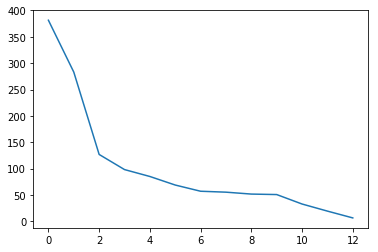

In [5]:
%matplotlib inline  
# We want to rank all attributes, and the best ones will be selected later
selector = SelectKBest(f_regression, k="all")
selector.fit(X_train, y_train)
sorted_attributes = np.argsort(-selector.scores_)
sorted_scores = np.sort(-selector.scores_)
for index,element in enumerate(zip(sorted_attributes, sorted_scores)):
    print element
    if index>10: break
        
plt.plot(-sorted_scores)
plt.show()

It seems that the first ten attributes have the highest scores. Let's see what happens if we select only those 9 attributes.

In [6]:
sorted_attributes

array([12,  5, 10,  2,  9,  4,  1,  6,  8,  0, 11,  7,  3], dtype=int64)

But before doing that, in order to get a meaningful comparison, we are going to re-order the attributes in the dataset, because it seems that decision trees give different results if the attributes appear in a different order in the dataset (even if the attributes are exactly the same!). So, first we obtain again the test results again with attributes in the original order. It can be seen that we get the same result as before (it is important to set the random state to the same value as before: 0. Probably we would get a different result by setting the random state to a different value)

In [7]:
clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print metrics.mean_squared_error(y_test, y_test_pred)

13.5348768473


Now, we re-order the attributes according to their relevance, and compute the test error again. Please, notice that the attributes are exactly the same, just in a different order! Even so, we get a different test result because the order of attributes is taken into account somehow by the decision tree sklearn implementation.

In [8]:
X_train_new = X_train[:, sorted_attributes]
X_test_new = X_test[:, sorted_attributes]

In [9]:
clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(X_train_new, y_train)
y_test_pred = clf.predict(X_test_new)
print metrics.mean_squared_error(y_test, y_test_pred)

16.9537438424


Now, we can see what happens if we use only the 10 most relevant attributes. We can see that the error is not too different, even though we have removed three attributes.

In [10]:
clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(X_train_new[:,:10], y_train)
y_test_pred = clf.predict(X_test_new[:,:10])
print metrics.mean_squared_error(y_test, y_test_pred)

16.9839901478


What we did before was to check that we can get approximately the same test error using fewer attributes. But we know that we cannot use the test set in order to select the optimal number of features, because we can only use the training set for that (or for tuning any other hyper-parameter, for that matter). We are going to do attribute selection properly by considering the number of attributes as a hyper-parameter.

In order to do that, we are going to construct a method which is a combination or a sequence (a pipeline, in fact) of an attribute selector + a decision tree regressor. clf is therefore the pipeline (a sequence of attribute selection + regression algorithm). The number of attributes to be selected is a hyper-parameter of clf. max_depth is also a hyper-parameter of clf. We can use grid search in order to tune both parameters at the same time. Please notice that we do the tuning using only the training set. At the end of GridSearch, clf_grid contains a model trained with the whole training set and the optimal hyper-parameters.

In [11]:
from sklearn.pipeline import Pipeline

param_grid = {'feature_selection__k': np.arange(X_train.shape[1])+1,
             'regression__max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14]}

clf = Pipeline([
  ('feature_selection', SelectKBest(f_regression)),
  ('regression', tree.DecisionTreeRegressor(random_state=0))
])

#n_jobs is for parallelizing gridsearch. It might be the case that it does
# not work well in Windows, hence n_jobs=1
np.random.seed(0)
clf_grid = GridSearchCV(clf, 
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=5 , n_jobs=1, verbose=1)
%time _ = clf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 169 candidates, totalling 845 fits
Wall time: 4.07 s


[Parallel(n_jobs=1)]: Done 845 out of 845 | elapsed:    4.0s finished


Now, let's see the best hyper-parameters. It seems that for this case, all the attributes should (13) should be used.

In [11]:
print clf_grid.best_params_, clf_grid.best_score_

{'feature_selection__k': 13, 'regression__min_samples_split': 12} -16.7080981493


Now, we test the tuned pipeline (clf_grid = attribute selection+tree) with the test partition. Please note, that at prediction time, clf_grid will first select the same 13 attributes selected in training, and then it will apply the decision tree trained on the training set.

In [12]:
y_test_pred = clf_grid.predict(X_test)
print metrics.mean_squared_error(y_test, y_test_pred)

13.8864672229


# USING PCA FOR TRANSFORMING ATTRIBUTES WITH TRAIN / TEST EVALUATION

In [13]:
from sklearn import decomposition
from sklearn import datasets

In [14]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=33)

(150L, 4L)


Let's use the maximum number of PCA components for the moment(4 iris attributes implies 4 PCA components)

In [15]:
pca = decomposition.PCA(n_components=4)
pca.fit(X_train)


PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Now, let's see how much variance explains each of the four components. We can see that the first component explaines most of the variance 92%

In [16]:
pca.explained_variance_ratio_

array([ 0.92337895,  0.05717063,  0.01542177,  0.00402865])

Now, let's compute the cummulative variance explained by n components. It seems that with 2 components we can already explain more than 95% of the variance. Using that criterion, we should use 2 components.

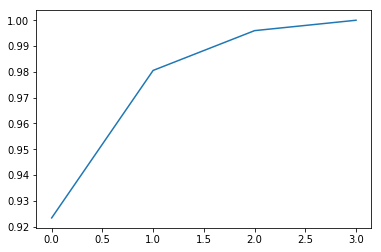

In [17]:
accumulated_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(accumulated_variance)
plt.show()


Therefore, let's compute 2 PCA components and apply them to train and test. We can see that the new input attributes (X_train_new and X_test_new have 2 new attributes) 

In [18]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_train)
X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)

Now, we can apply a classifier to the new, reduced, training set, and test it on the transformed test set

In [19]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train_new, y_train)

In [20]:
y_train_pred = clf.predict(X_train_new)
y_test_pred = clf.predict(X_test_new)
print metrics.accuracy_score(y_train, y_train_pred)
print metrics.accuracy_score(y_test, y_test_pred)

1.0
0.916666666667


If we construct the tree with the original dataset (before applying PCA), we see that test accuracy is larger with 4 attributes than with 2 PCA components. So in this case, PCA would not be useful from an accuracy point of view, but it would be useful to reduce the complexity of the model (with PCA we have only 2 components instead of the 4 original attributes).

In [22]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print metrics.accuracy_score(y_train, y_train_pred)
print metrics.accuracy_score(y_test, y_test_pred)

1.0
0.95


We might also consider that the number of PCA components to be selected is a hyper-parameter, and use a similar pipeline to the one at the first part of the tutorial, in order to select the right number of components.